# Introduction

---

As a business owner, customer reviews can be a valuable source of insight. Imagine being able to gradually monitor areas for improvement that increase customer satisfaction and highlight the best parts of the business for effective branding.

This project aims to segment user reviews into several topics for easier analysis.

The key components of our project include:
- **Review clustering**: to divide customer reviews into distinct clusters by representing the reviews as word vectors or word embeddings. The word vectors are obtained from several sources, such as pre-trained [Transformer model](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), self-train [Word2Vec model](https://radimrehurek.com/gensim/models/word2vec.html), concatenated word vectors, and fine-tuned Transformer model
- **Topic labeling**: to label review topics within each cluster using a large language model (LLM) API, such as OpenAI.

**Keywords**: review clustering, word vector, embedding, word2vec, transformer, fine-tuning

## Dataset

The dataset for this project is [Google Local dataset](https://cseweb.ucsd.edu/~jmcauley/datasets.html#google_local) obtained from J. McAuley lab.

Originally, the dataset contains millions of business reviews from across the United States up to 2021. However, for the sake of simplicity and due to limited resources for this project, we only choose the data from one state and one business type: **tourist attractions in Hawaii** ✨.

In the end, we settle with 1235 tourist attractions with approximately 260k customer reviews.

In [ ]:
!pip install pyarrow==17.0.0 pyarrow-hotfix==0.6 numpy==1.26.4 scipy==1.13.1
!pip install spacy==3.7.5 spacy-legacy==3.0.12 spacy-loggers==1.0.5
!pip install gensim==4.3.3 transformers==4.44.2 datasets==3.1.0 sentence-transformers==3.2.1 accelerate==0.34.2
!pip install openai==1.52.2
!python -m spacy download en_core_web_sm

In [2]:
from google.cloud import storage
from datetime import datetime
from openai import OpenAI

from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv
import io

In [3]:
# Helper function

def download_csv_from_gcs(bucket, file_name,
                          date_columns=None, col_names=None):
    """ A function to download dataset from GCS. """

    blob = bucket.blob(file_name)
    data = blob.download_as_text()
    df = pd.read_csv(io.StringIO(data),
                     parse_dates=date_columns,
                     usecols=col_names)
    return df

def upload_csv_to_gcs(df, bucket, file_path, sep=','):
    """ A function to upload dataset to GCS. """

    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False, quoting=csv.QUOTE_ALL, encoding='utf-8')

    blob = bucket.blob(file_path)
    blob.upload_from_string(csv_buffer.getvalue(), content_type='text/csv')

    print(f"Successfully uploaded: '{blob.name}' to '{bucket.name}'")

In [5]:
# Create a client GCS and get the specified bucket
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)

In [6]:
# Download the dataset from GCS
reviews_df = download_csv_from_gcs(bucket, REVIEW_CSV)

In [7]:
reviews_df.head()

,business_id,business_name,user_id,time,text
0,0x7954d184b450b1e7:0x4bee7e570ae07db8,Maui National Wildlife Refuge Complex,109709907397075607894,1521793918433,Went their for a field trip. It was awesome! s...
1,0x7954d184b450b1e7:0x4bee7e570ae07db8,Maui National Wildlife Refuge Complex,108968256029885805791,1574633258124,"Nice interpretation center, hard to find the w..."
2,0x7954d184b450b1e7:0x4bee7e570ae07db8,Maui National Wildlife Refuge Complex,113167915373388818291,1583292550820,Great water birds! Clean place and easy access!
3,0x7954d184b450b1e7:0x4bee7e570ae07db8,Maui National Wildlife Refuge Complex,117153367922518677632,1528995771126,Be sure to stop by the visitors center first. ...
4,0x7954d184b450b1e7:0x4bee7e570ae07db8,Maui National Wildlife Refuge Complex,112253051829957730666,1549652370655,Great outdoor excursion. Ponds next to the oce...


In [8]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259581 entries, 0 to 259580
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   business_id    259581 non-null  object
 1   business_name  259581 non-null  object
 2   user_id        259581 non-null  object
 3   time           259581 non-null  int64 
 4   text           259579 non-null  object
dtypes: int64(1), object(4)
memory usage: 9.9+ MB


In [9]:
# The dataset contains review from 2005-2021
reviews_df["time"] = pd.to_datetime(reviews_df["time"], unit="ms")
reviews_df["time"].min().strftime("%Y-%m-%d"), reviews_df["time"].max().strftime("%Y-%m-%d")

('2005-01-01', '2021-09-02')

In [10]:
# Count the number of unique businesses and users
reviews_df[["business_id", "user_id"]].nunique()

business_id      1235
user_id        127721
dtype: int64

In [11]:
# Count the average number of reviews for each business
int(reviews_df.groupby("business_id")["text"].count().mean())

210

In [12]:
# Check the missing values
reviews_df.isna().sum()

business_id      0
business_name    0
user_id          0
time             0
text             2
dtype: int64

In [13]:
reviews_df = reviews_df.dropna(subset=["text"])

Next, we divide the dataset into train and test data.

In [14]:
# The test sample is 10% from the entire dataset (around 120 business)
np.random.seed(2024)

n_sample = int(0.1 * reviews_df["business_id"].nunique())
test_data = np.random.choice(reviews_df["business_id"].unique(), n_sample, replace=False)

In [15]:
test_df = reviews_df[reviews_df["business_id"].isin(test_data)]
train_df = reviews_df[~reviews_df["business_id"].isin(test_data)]

In [16]:
train_df.shape, test_df.shape

((238358, 5), (21221, 5))

# Dataset Preparation

---



Before we begin word vector modeling and clustering, we preprocess our text dataset to prepare it for modeling. We apply general natural language processing (NLP) techniques, such as text cleaning, sentence segmentation, and tokenization. For this, we use Python library for NLP [Spacy](https://spacy.io/).

We noticed that the dataset treatment for the Transformer model is slightly different from that of the Word2Vec model, as stop words are not removed for the Transformer model in order to retain the full context. Hence we provide two outputs:
- Tokens: tokenized clean sentences without stop words for Word2Vec training.
- Clean text: clean sentence with most words are retained for fine-tuning or decoding with Transformer model.

In [17]:
import en_core_web_sm

import re

In [18]:
spacy_nlp = en_core_web_sm.load()

In [19]:
class ProcessDataset():
    """
      A class for preprocessing review data for training downstream models.
      Preprocessing includes:
        - Cleaning, splitting, and expanding sentences
        - Tokenizing and removing stop words from sentences
    """

    def __init__(self, spacy_nlp):

        self.nlp = spacy_nlp

    def _clean_text(self, text):
        """ Clean text from unnecessary tokens/substrings """

        # Remove emoji patterns
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # Emoticons
            "\U0001F300-\U0001F5FF"  # Symbols & pictographs
            "\U0001F680-\U0001F6FF"  # Transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
            "\U00002700-\U000027BF"  # Dingbats
            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            "\U00002600-\U000026FF"  # Misc symbols
            "\U00002B50-\U00002B59"  # Stars
            "]+", flags=re.UNICODE
        )
        text = emoji_pattern.sub(r"", text)

        # Extracts text between '(Translated by Google)' and '(Original)'.
        match = re.search(r"\(Translated by Google\)(.+?)  ", text)
        if match:
            text = match.group(1)

        return text

    def _split_and_tokenize(self, text):
        """
          Splits text into sentences using the spaCy model.
          Also tokenize and lemmatize.
        """

        sents = [sent for sent in self.nlp(text.lower()).sents if sent.text]

        full_sents = [sent.text for sent in sents]

        tokenized = [[ token.lemma_ for token in sent
                      if token.is_alpha
                        and not token.is_punct
                        and not token.is_stop ]
                     for sent in sents ]
        tokenized = [" ".join(sent) for sent in tokenized]
        # We do the above operation so that it can be exploded later

        return full_sents, tokenized

    def transform(self, dataset):
        """ The main text processing function. """

        data = dataset.copy()

        # Clean, split, and expand sentences
        data["text"] = data["text"].apply(self._clean_text)
        data.loc[:, ["clean_text", "tokens"]] = data["text"].apply(
            self._split_and_tokenize).apply(
                lambda x: pd.Series(x, index=["clean_text", "tokens"]))

        # Sentences with less than 10 letters are filtered out since it is assumed
        # that they contain less information
        data = data.explode(["clean_text", "tokens"]).reset_index(drop=True)
        data = data[data["clean_text"].str.len() >= 10]

        # Tokenize sentence
        # Sentences with less than 5 words are also filtered out with the same reasoning
        data["tokens"] = data["tokens"].apply(lambda x: x.split())
        data = data[data["tokens"].apply(lambda x: len(x) >= 5)]

        return data

In [20]:
data_processor = ProcessDataset(spacy_nlp)

In [21]:
train_dataset = data_processor.transform(train_df)

In [22]:
train_dataset[["clean_text", "tokens"]].head()

,clean_text,tokens
2,sometimes the road to the pond is flooded so y...,"[road, pond, flood, balance, concrete, block, ..."
4,i recommend this place for tourists and i do n...,"[recommend, place, tourist, recommend, litter,..."
5,"nice interpretation center, hard to find the w...","[nice, interpretation, center, hard, find, wil..."
11,free to visit and they supply you with binocul...,"[free, visit, supply, binocular, bird, identif..."
12,"if the water level is high, be prepared to get...","[water, level, high, prepared, little, wet, wa..."


In [23]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229781 entries, 2 to 567575
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   business_id    229781 non-null  object        
 1   business_name  229781 non-null  object        
 2   user_id        229781 non-null  object        
 3   time           229781 non-null  datetime64[ns]
 4   text           229781 non-null  object        
 5   clean_text     229781 non-null  object        
 6   tokens         229781 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 14.0+ MB


# Helper Functions

---



This section contains some helper functions, including review selection, cluster evaluation, cluster visualization, and cluster naming.

For cluster visualization, we use the Python library [Plotly](https://plotly.com/). For cluster naming, we use the [OpenAI API](https://platform.openai.com/docs/overview). The details can be found in the function implementations below.

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [98]:
# Helper functions for data selection, cluster evaluation, and visualization
class HDBSCANClustering(BaseEstimator, TransformerMixin):

    def __init__(self, apply_dim_reduction=False):
        self.model = HDBSCAN(metric="cosine",
                             min_cluster_size=2,
                             cluster_selection_epsilon=0.1)
        self.labels_ = None

        # Apply PCA to remove correlation and reduce dimension. 
        # This supposedly improve clustering result.
        self.apply_dim_reduction = apply_dim_reduction
        self.reducer = PCA()

    def fit(self, X, y=None):
        """ Fit the cluster. """

        # Optionally apply PCA before clustering
        if self.apply_dim_reduction:
            X = self.reducer.fit_transform(X)

        # Predict the label
        self.labels_ = self.model.fit_predict(X)
        return self

    def transform(self, X):
        """ Return the label """
        
        return self.labels_

def select_dataset(dataset, business_id, sentiment_model):
    """
      Select dataset based on the business_id on the past 6 months time period,
      also encode the sentiment using a pretrained model.
    """

    # Select data based on `business_id`
    data = dataset[dataset["business_id"] == business_id].copy()

    # Select reviews from last years
    time_limit = data["time"].max() - pd.DateOffset(months=12)
    data = data[data["time"] >= time_limit]

    # Extract the sentiment using a pretrained model
    data["sentiment"] = data["clean_text"].apply(lambda x: sentiment_model(x))
    data["sentiment"] = data["sentiment"].apply(lambda x: x[0]["label"])

    return data

def evaluate_cluster(X, y, name):
    """
        Evaluate clustering result using 3 evaluation metrics:
        1. `silhouette_score`: a metric used to calculate the goodness of fit
            of a clustering algorithm. Its value ranges from -1 to 1.
        2. `davies_bouldin_score`: the average similarity measure of each cluster
            with its most similar cluster. The minimum value is 0 for better model.
        3. `calinski_harabasz_score`: the ratio of the sum of between-cluster dispersion
            and of within-cluster dispersion. Higher index indicates separable clusters.
    """
    evaluation_scores = {}
    evaluation_scores["silhouette_score"] = [silhouette_score(X, y)]
    evaluation_scores["davies_bouldin_score"] = [davies_bouldin_score(X, y)]
    evaluation_scores["calinski_harabasz_score"] = [calinski_harabasz_score(X, y)]

    return pd.DataFrame(evaluation_scores,
                        index=[f"{name.title()} Reviews"]).T

def visualize_cluster(fig, df, x_column, y_column,
                      row=None, sentiment="positive", show_outliers=True):
    
    """ Visualize the review clusters """
    
    # To exclude or include the data labeled as "noise"
    if not show_outliers:
        n_noise = df[df[y_column] == "Other"][y_column].count()
        print(f"Outliers ratio ({sentiment}): {n_noise}/{len(df)}")
        
        df = df[df[y_column] != "Other"].copy()

    # Perform PCA transformation for visualization
    pca = PCA(n_components=2)
    df["pca"] = list(pca.fit_transform(np.vstack(df[x_column].values)))
    df[["pca_x", "pca_y"]] = pd.DataFrame(df["pca"].tolist(), index=df.index)

    # Encode the cluster label as category
    df[y_column] = df[y_column].astype("category")

    # Plot with px.scatter using the new PCA columns
    fig_px = px.scatter(df,
                        x="pca_x",
                        y="pca_y",
                        color=df[y_column],
                        hover_data={"clean_text": True, y_column: True,
                                    "pca_x": False, "pca_y": False},
                        color_discrete_sequence=px.colors.qualitative.Set1)

    # Add this plot to the subplot column
    for trace in fig_px.data:
        trace.legendgroup = row
        trace.showlegend = True
        fig.add_trace(trace, row=row, col=1)

client = OpenAI(
    api_key = api_key
)

def get_cluster_centroids(data, wv_col, label_col, n):
    """ Get the top n-items closest to the cluster. """

    # Remove the items labeled as "noise", this will be labeled as "Other".
    data = data[data[label_col] > 0]

    # Get the unique cluster
    unique_clusters = np.unique(data[label_col])

    text_data = {}
    for id_ in unique_clusters:
        # Get the cluster data
        cluster_data = data[data[label_col] == id_]
        cluster_wv = np.array(cluster_data[wv_col].tolist())

        # Calculate the centroid by taking the mean
        centroid = np.mean(cluster_wv, axis=0)

        # Compute the distance to the centroid for each item
        distances = np.linalg.norm(cluster_wv - centroid, axis=1)

        # Get the top n-items
        closest_indices = np.argsort(distances)[:n]

        # Collect the text
        closest_texts = cluster_data.iloc[closest_indices]["clean_text"].tolist()
        text_data[id_] = closest_texts

    return text_data

def name_cluster(text_samples):
    """
      Name the cluster based on the review's content using OpenAI API.
    """

    prompt = f"""
        You are an expert in giving a descriptive topic to a given list of sentences.
        The sentences may have different topics, so choose the commonly shared one.
        Please return the topic as consice as possible, maximum in 3 words.

        There are maximum of 5 sentences as the input.
        The content of the sentences is limited to customer reviews for a tourist attraction sites.

        Here is an example with 3 setences:

        INPUT
        'Gorgeous place to visit, it can get crowded on holidays.'
        'Great hike and beautiful views.'
        'Awesome view.'
        ENDINPUT

        LABEL 'Scenic view'

        So here is the sentences:
        INPUT
        {text_samples}
        ENDINPUT

        LABEL ...
    """
    # Create a request
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )

    return response.choices[0].message.content

# `SentenceTransformer` Model

---



Our goal in this project is to group customer reviews into clusters based on the topics of the reviews. To do this, the appropriate feature representation is **word vectors**.

To obtain word vectors from a sentence, we commonly use deep neural networks, either by training a model ourself or by using a pretrained one. Nowadays, several pretrained models are available for extracting word vectors.

The advantage of using a pretrained model is that its trained using advanced network on a large and diverse dataset. Though, the disavantage is that it may be less specific to the dataset. However, in general, these pretrained models perform well in most cases.

In this project, we use a pre-trained lightweight but high-performing model, [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2). To make the **sentence-level embedding extraction** easier, we use the [`SentenceTransformer` framework](https://github.com/UKPLab/sentence-transformers).

Before we do the clustering, we divided the reviews based on its sentiment (positive/negative). For this task, we also use a pre-trained sentiment model, `cardiffnlp/twitter-roberta-base-sentiment-latest`.

## Clustering

In [26]:
from sentence_transformers import SentenceTransformer
from transformers import pipeline

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [27]:
transformer_wv_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
sentiment_model = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
class TransformerWVEncoder(BaseEstimator, TransformerMixin):
    """ Wrap the transformer model to make it compatible with scikit-learn. """

    def __init__(self, model):
        # Load the Transformer model
        self.model = model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """ Transform the data using the transformer model. """

        # We use the unit vector of the word embedding (magnitude=1)
        wv = X.apply(lambda x: self.model.encode(x, normalize_embeddings=True))
        return wv

In [30]:
transformer_encoder = TransformerWVEncoder(transformer_wv_model)

In [91]:
business_id = np.random.choice(train_dataset["business_id"])

Business name: Haleakalā National Park

Number of positive reviews: 69
Outliers ratio (positive): 22/69

Number of negative reviews: 12
Outliers ratio (negative): 3/12



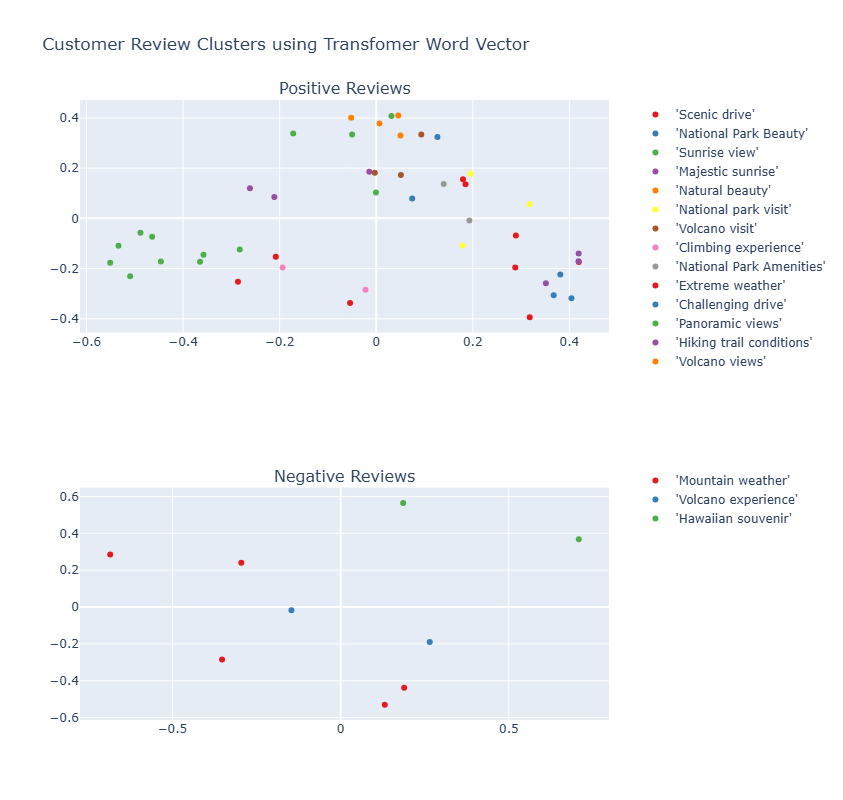

In [99]:
# Filter the dataset based on "business_id"
selected_data = select_dataset(train_dataset, business_id, sentiment_model)
print(f"Business name: {selected_data['business_name'].unique()[0]}\n")

# Get the word vector from the pretrained transformer model
selected_data["tfm"] = transformer_encoder.transform(selected_data["clean_text"])

# Initialize evaluation results
evaluation = []

# Initialize subplots
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=["Positive Reviews", "Negative Reviews"])

for i, sentiment in enumerate(["positive", "negative"], start=1):

    # Prepare data for clustering by filtering it based on the sentiment
    X = selected_data[selected_data["sentiment"] == sentiment].copy()
    X_ = np.vstack(X["tfm"].values)
    print(f"Number of {sentiment} reviews: {len(X)}")

    # Clustering
    clust = HDBSCANClustering(apply_dim_reduction=True)
    X["label"] = clust.fit_transform(X_)

    # Evaluation
    evaluation.append(evaluate_cluster(X_, X["label"], sentiment))

    # Clusters' topic extraction
    cluster_text = get_cluster_centroids(X, "tfm", "label", n=2)
    cluster_label = {}
    for key in cluster_text:
        cluster_label[key] = name_cluster("\n".join(cluster_text[key]))
    
    # Fill label as "Other" for reviews considered as noise by HDBSCAN
    X["label"] = X["label"].map(cluster_label).fillna("Other")

    # Visualization
    visualize_cluster(fig, X, "tfm", "label",
                      row=i, sentiment=sentiment, show_outliers=False)

    print()

fig.update_layout(
    height=800,
    width=1000,
    title="Customer Review Clusters using Transfomer Word Vector",
    legend=dict(
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.05,
        tracegroupgap=100
    )
)
fig.show()

![tfm](https://github.com/fandayp/exploratory_projects/blob/main/img/wv_tfm.png?raw=true)

In [100]:
# Evaluation
tfm_eval = pd.concat(evaluation, axis=1)
tfm_eval

,Positive Reviews,Negative Reviews
silhouette_score,0.042847,0.026767
davies_bouldin_score,2.047620,1.513416
calinski_harabasz_score,2.201999,1.267612


# Word2Vec Model

---



In the previous section, we saw that clustering with word vectors from Transformer model provides some separation. However, the result is unsatisfactory, especially the number reviews labeled as noise/outliers by the clustering model.

A common approach to improve the fit of a pretrained model to a specific dataset is fine-tuning. However, this requires large computational resources.

Alternatively, we can train a custom model and then **concatenate** its word vectors with those from the pretrained model before clustering. We trained a custom Word2Vec model on our review dataset to create word vectors specific to our data. This option (Word2Vec) is worth to be explored since the training time is much faster than fine-tuning Transformer model. The result is also comparable, if not, better.

## Training

In [34]:
from gensim.models import Word2Vec

In [35]:
class W2VEncoder(BaseEstimator, TransformerMixin):
    """ Wrap the Word2Vec model to make it compatible with scikit-learn. """

    def __init__(self, model=None, norm=True):
        # Use any existing w2v model
        self.model = model
        self.norm = norm

        # Model hyperparameters
        self.vector_size = 384
        self.window = 3
        self.min_count = 3
        self.epochs = 5
        self.alpha = 0.01
        self.min_alpha = 0.001

    def fit(self, X, y=None):
        """ Train the w2v model. """

        # If not pretrained model isn't provided, train a new model
        if not self.model:
            self.model = Word2Vec(X,
                                  vector_size=self.vector_size,
                                  window=self.window,
                                  min_count=self.min_count,
                                  compute_loss=True,
                                  epochs=self.epochs,
                                  alpha=self.alpha,
                                  min_alpha=self.min_alpha)

        print("Finished training!")
        print(f"Latest training loss (cumulative): {self.model.get_latest_training_loss()}")

        return self

    def transform(self, X):
        """
            Transform the data using the learned w2v model.
            X is a Series
        """

        # Extract the word vector for each token
        wv = X.apply(lambda tokens: [self.model.wv.get_vector(token)
                                    for token in tokens if token in self.model.wv])

        # Take the average of the word vectors
        wv = wv.apply(lambda v: np.array(v).mean(0) if len(v)
                                else np.zeros(self.vector_size))
        
        # Normalize the averaged word vectors
        if self.norm:
            wv = wv.apply(lambda v: v / np.linalg.norm(v))

        return wv

In [36]:
# Train the Word2Vec model
w2v_encoder = W2VEncoder()
w2v_encoder.fit(train_dataset["tokens"])

Finished training!
Latest training loss (cumulative): 5725937.0


W2VEncoder(model=<gensim.models.word2vec.Word2Vec object at 0x7f46972165c0>)

## Clustering

Business name: Haleakalā National Park

Number of positive reviews: 69
Outliers ratio (positive): 17/69

Number of negative reviews: 12
Outliers ratio (negative): 6/12



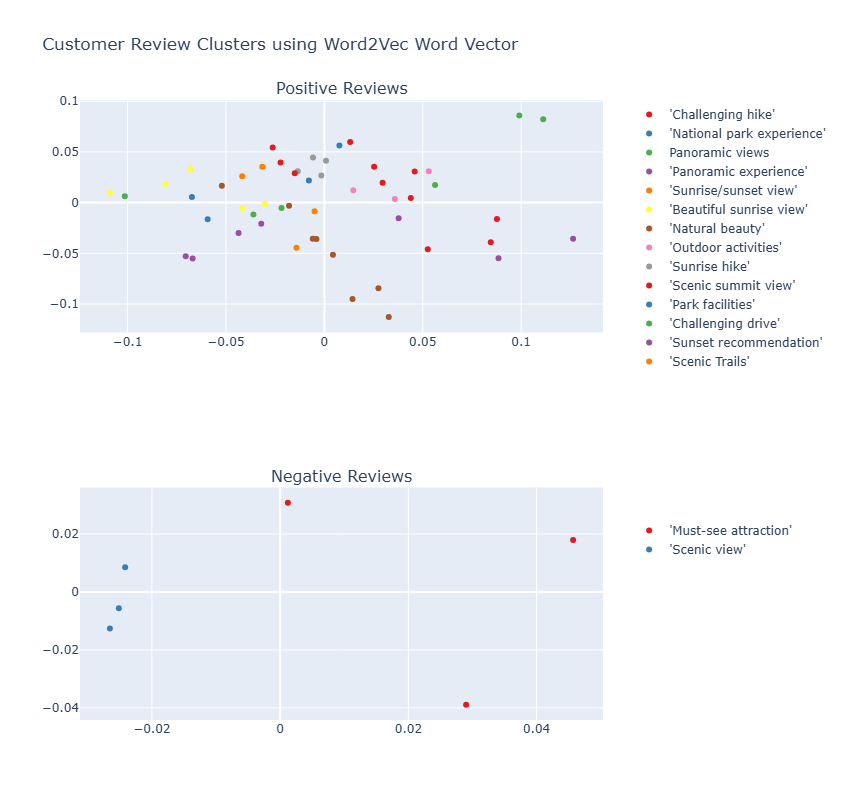

In [110]:
# Filter the dataset based on "business_id"
selected_data = select_dataset(train_dataset, business_id, sentiment_model)
print(f"Business name: {selected_data['business_name'].unique()[0]}\n")

# Get the word vector from the pretrained transformer model
selected_data["w2v"] = w2v_encoder.transform(selected_data["clean_text"])

# Initialize evaluation results
evaluation = []

# Initialize subplots
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=["Positive Reviews", "Negative Reviews"])

for i, sentiment in enumerate(["positive", "negative"], start=1):

    # Prepare data for clustering by filtering it based on the sentiment
    X = selected_data[selected_data["sentiment"] == sentiment].copy()
    X_ = np.vstack(X["w2v"].values)
    print(f"Number of {sentiment} reviews: {len(X)}")

    # Clustering
    clust = HDBSCANClustering(apply_dim_reduction=True)
    X["label"] = clust.fit_transform(X_)

    # Evaluation
    evaluation.append(evaluate_cluster(X_, X["label"], sentiment))

    # Clusters' topic extraction
    cluster_text = get_cluster_centroids(X, "w2v", "label", n=2)
    cluster_label = {}
    for key in cluster_text:
        cluster_label[key] = name_cluster("\n".join(cluster_text[key]))
    
    # Fill label as "Other" for reviews considered as noise by HDBSCAN
    X["label"] = X["label"].map(cluster_label).fillna("Other")

    # Visualization
    visualize_cluster(fig, X, "w2v", "label",
                      row=i, sentiment=sentiment, show_outliers=False)

    print()

fig.update_layout(
    height=800,
    width=1000,
    title="Customer Review Clusters using Word2Vec Word Vector",
    legend=dict(
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.05,
        tracegroupgap=150
    )
)
fig.show()

![w2v](https://github.com/fandayp/exploratory_projects/blob/main/img/wv_w2v.png?raw=true)

In [103]:
# Evaluation
w2v_eval = pd.concat(evaluation, axis=1)
w2v_eval

,Positive Reviews,Negative Reviews
silhouette_score,0.044464,0.120030
davies_bouldin_score,1.302124,1.328076
calinski_harabasz_score,7.526245,4.203363


In [104]:
tfm_eval

,Positive Reviews,Negative Reviews
silhouette_score,0.042847,0.026767
davies_bouldin_score,2.047620,1.513416
calinski_harabasz_score,2.201999,1.267612


We can see some improvement in the evaluation score. Note that for `davies_bouldin_score`, smaller score is better.

# Concatenated Word Vectors

---



In this section, we **concatenate** the word vectors from Word2Vec with the one generated by Transformer model. 
We want to see if this can improve the result.

Business name: Haleakalā National Park

Number of positive reviews: 69
Outliers ratio (positive): 23/69

Number of negative reviews: 12
Outliers ratio (negative): 2/12



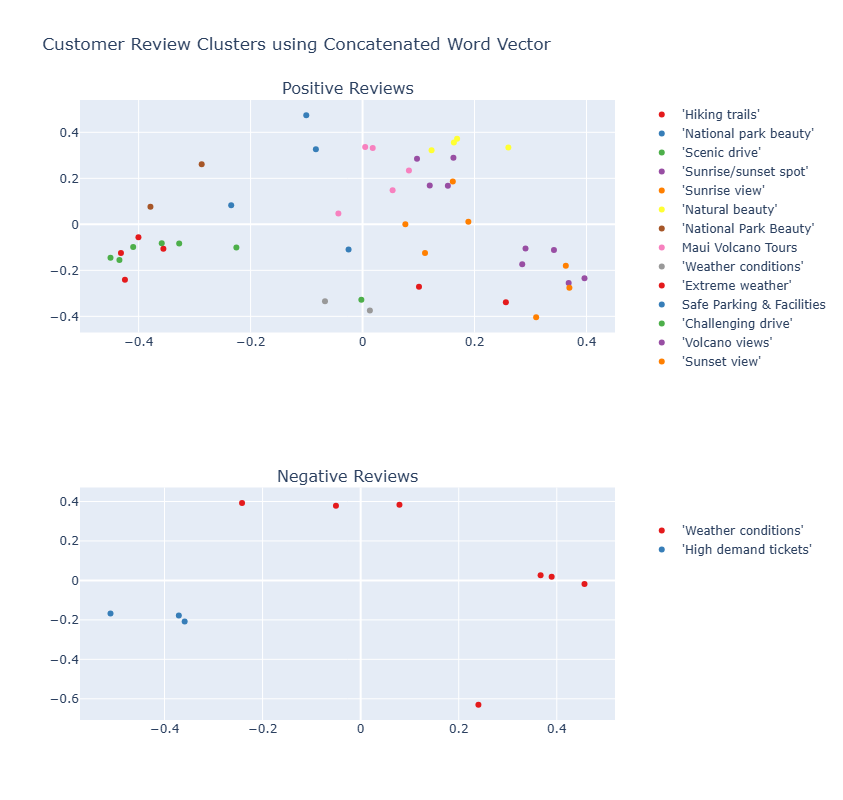

In [111]:
# Filter the dataset based on "business_id"
selected_data = select_dataset(train_dataset, business_id, sentiment_model)
print(f"Business name: {selected_data['business_name'].unique()[0]}\n")

# Get the word vector from the pretrained transformer model and word2vec model
selected_data["w2v"] = w2v_encoder.transform(selected_data["tokens"])
selected_data["tfm"] = transformer_encoder.transform(selected_data["clean_text"])
selected_data["concat"] = selected_data[["w2v", "tfm"]].apply(
                          lambda x: np.hstack([x["w2v"], x["tfm"]]), axis=1
                      )

# Normalize the concatenated vectors
selected_data["concat"] = selected_data["concat"].apply(
                          lambda v: v / np.linalg.norm(v))

# Initialize evaluation results
evaluation = []

# Initialize subplots
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=["Positive Reviews", "Negative Reviews"])

for i, sentiment in enumerate(["positive", "negative"], start=1):

    # Prepare data for clustering by filtering it based on the sentiment
    X = selected_data[selected_data["sentiment"] == sentiment].copy()
    X_ = np.vstack(X["concat"].values)
    print(f"Number of {sentiment} reviews: {len(X)}")

    # Clustering
    clust = HDBSCANClustering(apply_dim_reduction=True)
    X["label"] = clust.fit_transform(X_)

    # Evaluation
    evaluation.append(evaluate_cluster(X_, X["label"], sentiment))

    # Clusters' topic extraction
    cluster_text = get_cluster_centroids(X, "concat", "label", n=2)
    cluster_label = {}
    for key in cluster_text:
        cluster_label[key] = name_cluster("\n".join(cluster_text[key]))
    
    # Fill label as "Other" for reviews considered as noise by HDBSCAN
    X["label"] = X["label"].map(cluster_label).fillna("Other")

    # Visualization
    visualize_cluster(fig, X, "concat", "label",
                      row=i, sentiment=sentiment, show_outliers=False)

    print()

fig.update_layout(
    height=800,
    width=1000,
    title="Customer Review Clusters using Concatenated Word Vector",
    legend=dict(
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.05,
        tracegroupgap=150
    )
)
fig.show()

![concat](https://github.com/fandayp/exploratory_projects/blob/main/img/wv_cat.png?raw=true)

In [112]:
# Evaluation
concat_eval = pd.concat(evaluation, axis=1)
concat_eval

,Positive Reviews,Negative Reviews
silhouette_score,0.030193,0.055074
davies_bouldin_score,1.959363,1.866525
calinski_harabasz_score,2.415373,1.483818


In [113]:
tfm_eval

,Positive Reviews,Negative Reviews
silhouette_score,0.042847,0.026767
davies_bouldin_score,2.047620,1.513416
calinski_harabasz_score,2.201999,1.267612


In [114]:
w2v_eval

,Positive Reviews,Negative Reviews
silhouette_score,0.044464,0.120030
davies_bouldin_score,1.302124,1.328076
calinski_harabasz_score,7.526245,4.203363


The result of vector concatenation performed worse than using either the Word2Vec or Transformer model individually. There may be discrepancies in the statistical properties of the word vectors, which, concatenation (and vector normalization) significantly decrease the overall performance. But at least it decreases the outliers count.

Since the Word2Vec model trained on our own dataset outperforms the Transformer model, it may be worthwhile to try fine-tuning the `SentenceTransformer` model using our review dataset.

Given that this is a clustering task without explicit labels, we can fine-tune the Transformer model using the masked language modeling (MLM) approach. Once the training is complete, we can wrap the model in the `SentenceTransformer` framework to generate sentence-level embeddings.

# `SentenceTransformer` Model Fine-tuning

## Dataset preparation

We followed the whole fine-tuning process from the [tutorial here](https://huggingface.co/learn/nlp-course/chapter7/3).

In [69]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer
from datasets import Dataset

from torch.utils.data import DataLoader

import random
import os

In [70]:
model_checkpoint = "sentence-transformers/all-MiniLM-L6-v2"

transformer_base_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
n_params = transformer_base_model.num_parameters() // 1_000_000

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print(f"\nModel's number of parameters is {n_params}M")

Some weights of BertForMaskedLM were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model's number of parameters is 22M


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [71]:
# """ NOTE: This section is just for sanity check """

# import torch

# text = "This is a great [MASK]."

# inputs = tokenizer(text, return_tensors="pt")
# token_logits = transformer_base_model(**inputs).logits
# # torch.Size([1, 8, 30522])

# print("mask_token_id", tokenizer.mask_token_id)
# for key in inputs:
#     print("\t", key, inputs[key])
# print()

# # Find the location of [MASK] and extract its logits
# mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
# mask_token_logits = token_logits[0, mask_token_index, :]

# # Pick the [MASK] candidates with the highest logits
# top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

# for token in top_5_tokens:
#     print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

Following a common preprocessing step in training masked language model, we concatenate all the examples and then split the whole corpus into chunks of equal size.

Note that the average number of tokens in our review sentences is 16 tokens. Hence, we will define the chunk size as 16 tokens.

In [72]:
# Mask the dataset
def tokenize_function(examples):
    """ Tokenize sentences """

    # Encode text
    result = tokenizer(examples["text"])

    return result

def group_texts(examples):
    """ Concatenate tokens and divide them into smaller chunks """

    chunk_size = 16

    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}

    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    # Drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size

    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }

    # Create a new labels column
    result["labels"] = result["input_ids"].copy()

    return result

In [73]:
train_text = train_dataset["clean_text"].values
review_dataset = Dataset.from_dict({"text": train_text})

# Tokenize
tokenized_datasets = review_dataset.map(
    tokenize_function, batched=True, remove_columns=["text"]
)

# Concat and divide into chunks
lm_datasets = tokenized_datasets.map(group_texts, batched=True)

lm_datasets

Map:   0%|          | 0/229781 [00:00<?, ? examples/s]

Map:   0%|          | 0/229781 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 304734
})

Notice that our dataset rows grow to around 300k sentences.

Next, we randomly replace words with `[MASK]`.

In [74]:
# 15% fraction of tokens to mask the amount used for BERT and a common choice in the literature
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [75]:
samples = [lm_datasets[i] for i in range(2)]

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] sometimes [MASK] road to the pond is flooded so [MASK] have to balance on concrete'

'>>> blocks it was like an adventure! [SEP] [CLS] i recommend [MASK] place for tourists and'


In [76]:
train_size = int(0.9 * len(lm_datasets))
test_size = int(0.1 * len(lm_datasets))

finetuning_dataset = lm_datasets.train_test_split(
    train_size=train_size, test_size=test_size, seed=2024
)
finetuning_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 274260
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 30473
    })
})

In [77]:
batch_size = 64

train_dataloader = DataLoader(
    finetuning_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    finetuning_dataset["test"], 
    batch_size=batch_size, 
    collate_fn=data_collator,
    drop_last=True
)

## Fine-tuning

In [78]:
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm

from sentence_transformers import SentenceTransformer, models

import torch
import math

In [79]:
class TransformerFineTune(BaseEstimator, TransformerMixin):

    def __init__(self,
                 model,
                 tokenizer,
                 lr=1e-5,
                 num_train_epochs=3,
                 num_update_steps_per_epoch=1000):
        
        self.tokenizer = tokenizer
        
        self.epochs = num_train_epochs
        self.lr = lr
        
        self.model = model
        self.optimizer = AdamW(model.parameters(), lr=lr)
        
        self.accelerator = Accelerator()
        
        self.num_train_epochs = num_train_epochs
        self.num_update_steps_per_epoch = num_update_steps_per_epoch
        self.num_training_steps = num_train_epochs * num_update_steps_per_epoch

        self.lr_scheduler = get_scheduler(
            "linear",
            optimizer=self.optimizer,
            num_warmup_steps=0,
            num_training_steps=self.num_training_steps,
        )
        
        self.output_dir = "./fine-tuned"
        
    def fit(self, train_dataloader, eval_dataloader):
        
        model, optimizer, train_dataloader, eval_dataloader = self.accelerator.prepare(
            self.model, self.optimizer, train_dataloader, eval_dataloader
        )

        progress_bar = tqdm(range(self.num_training_steps))

        for epoch in range(self.num_train_epochs):
            model.train()
            for batch in train_dataloader:
                
                outputs = model(**batch)
                loss = outputs.loss
                self.accelerator.backward(loss)

                optimizer.step()
                self.lr_scheduler.step()
                optimizer.zero_grad()
                
                progress_bar.update(1)

            model.eval()
            losses = []
            for step, batch in enumerate(eval_dataloader):
                with torch.no_grad():
                    outputs = model(**batch)

                loss = outputs.loss
                losses.append(self.accelerator.gather(loss.repeat(batch_size)))

            losses = torch.cat(losses)
            try:
                perplexity = math.exp(torch.mean(losses))
            except OverflowError:
                perplexity = float("inf")

            print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

            # Save
            self.accelerator.wait_for_everyone()
            unwrapped_model = self.accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(self.output_dir, 
                                            save_function=self.accelerator.save)
            if self.accelerator.is_main_process:
                self.tokenizer.save_pretrained(self.output_dir)
        
        fine_tuned_model = models.Transformer(self.output_dir, 
                                              tokenizer_name_or_path=self.output_dir)
        
        pooling_model = models.Pooling(fine_tuned_model.get_word_embedding_dimension(), 
                                       pooling_mode_mean_tokens=True,
                                       pooling_mode_cls_token=False,
                                       pooling_mode_max_tokens=False)

        self.model = SentenceTransformer(modules=[fine_tuned_model, pooling_model])
        return self

    def transform(self, X):
        """ Transform the data using the transformer model. """

        # We use the unit vector of the word embedding (magnitude=1)
        wv = X.apply(lambda x: self.model.encode(x, normalize_embeddings=True))
        return wv

In [80]:
# hyperparameters
fine_tune_config = {
    "lr": 5e-5,
    "num_train_epochs": 2,
    "num_update_steps_per_epoch": len(train_dataloader)
}

fine_tuned_encoder = TransformerFineTune(transformer_base_model,
                                       tokenizer, 
                                       **fine_tune_config)

fine_tuned_encoder.fit(train_dataloader, val_dataloader)

  0%|          | 0/8572 [00:00<?, ?it/s]

>>> Epoch 0: Perplexity: 44.52650555972225
>>> Epoch 1: Perplexity: 37.90721156246386


Some weights of BertModel were not initialized from the model checkpoint at ./fine-tuned and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TransformerFineTune(lr=5e-05,
                    model=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedm...
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
})

## Clustering

Business name: Haleakalā National Park

Number of positive reviews: 69
Outliers ratio (positive): 18/69

Number of negative reviews: 12
Outliers ratio (negative): 7/12



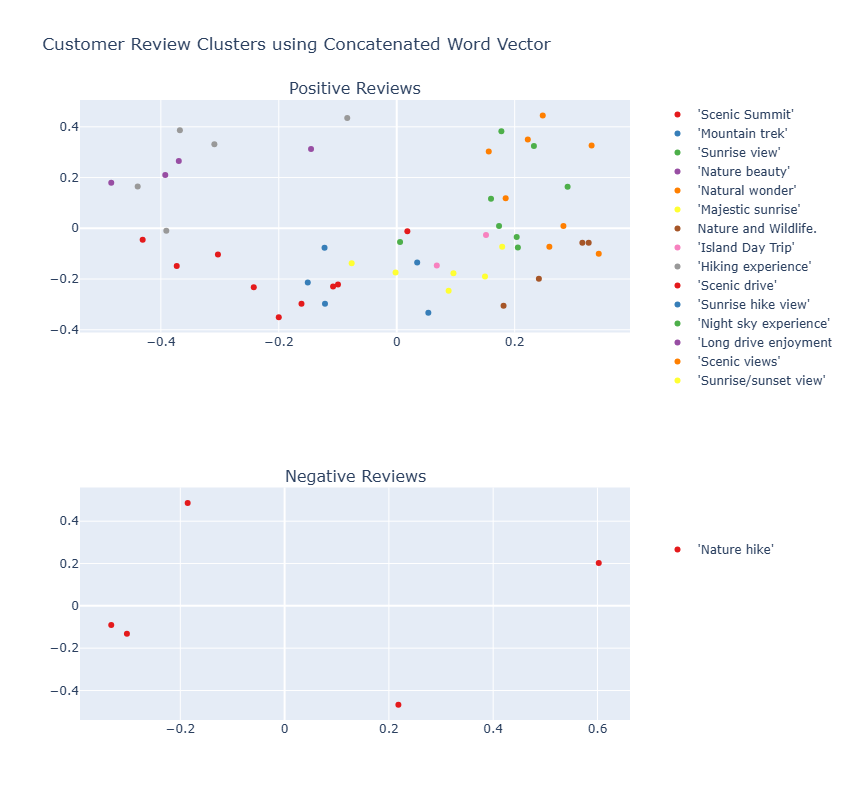

In [122]:
# Filter the dataset based on "business_id"
selected_data = select_dataset(train_dataset, business_id, sentiment_model)
print(f"Business name: {selected_data['business_name'].unique()[0]}\n")

# Get the word vector from the pretrained transformer model and word2vec model
selected_data["fine_tuned"] = fine_tuned_encoder.transform(selected_data["clean_text"])

# Initialize evaluation results
evaluation = []

# Initialize subplots
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=["Positive Reviews", "Negative Reviews"])

for i, sentiment in enumerate(["positive", "negative"], start=1):

    # Prepare data for clustering by filtering it based on the sentiment
    X = selected_data[selected_data["sentiment"] == sentiment].copy()
    X_ = np.vstack(X["fine_tuned"].values)
    print(f"Number of {sentiment} reviews: {len(X)}")

    # Clustering
    clust = HDBSCANClustering(apply_dim_reduction=True)
    X["label"] = clust.fit_transform(X_)

    # Evaluation
    evaluation.append(evaluate_cluster(X_, X["label"], sentiment))

    # Clusters' topic extraction
    cluster_text = get_cluster_centroids(X, "fine_tuned", "label", n=2)
    cluster_label = {}
    for key in cluster_text:
        cluster_label[key] = name_cluster("\n".join(cluster_text[key]))
    
    # Fill label as "Other" for reviews considered as noise by HDBSCAN
    X["label"] = X["label"].map(cluster_label).fillna("Other")

    # Visualization
    visualize_cluster(fig, X, "fine_tuned", "label",
                      row=i, sentiment=sentiment, show_outliers=False)

    print()

fig.update_layout(
    height=800,
    width=1000,
    title="Customer Review Clusters using Concatenated Word Vector",
    legend=dict(
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.05,
        tracegroupgap=150
    )
)
fig.show()

![tun](https://github.com/fandayp/exploratory_projects/blob/main/img/wv_tun.png?raw=true)

In [116]:
# Evaluation
fine_tuned_eval = pd.concat(evaluation, axis=1)
fine_tuned_eval

,Positive Reviews,Negative Reviews
silhouette_score,0.030882,0.093785
davies_bouldin_score,1.931764,2.050276
calinski_harabasz_score,2.539025,2.262458


In [118]:
tfm_eval

,Positive Reviews,Negative Reviews
silhouette_score,0.042847,0.026767
davies_bouldin_score,2.047620,1.513416
calinski_harabasz_score,2.201999,1.267612


In [117]:
w2v_eval

,Positive Reviews,Negative Reviews
silhouette_score,0.044464,0.120030
davies_bouldin_score,1.302124,1.328076
calinski_harabasz_score,7.526245,4.203363


We observe an improvement in the evaluation score for the fine-tuned Transformer model compared to the base Transformer model. However, the Word2Vec model still generally outperforms both.

Next, we will conduct an evaluation on a larger test set.

# Evaluation

In [119]:
# Preprocess the test data
test_dataset = data_processor.transform(test_df)

In [120]:
# Evaluate all the models using the test data

scores = []
for business_idx in test_data:
    selected_data = select_dataset(test_dataset, business_idx, sentiment_model)

    if len(selected_data):

        # Get the word vector from the trained Word2Vec model
        selected_data["w2v"] = w2v_encoder.transform(selected_data["tokens"])
        selected_data["tfm"] = transformer_encoder.transform(selected_data["clean_text"])
        selected_data["concat"] = selected_data[["w2v", "tfm"]].apply(
                                      lambda x: np.hstack([x["w2v"], x["tfm"]]), axis=1
                                  )
        
        selected_data["fine_tuned"] = fine_tuned_encoder.transform(
                                            selected_data["clean_text"])

        for i, sentiment in enumerate(["positive", "negative"], start=1):

            # Prepare data for clustering by filtering it based on the sentiment
            X = selected_data[selected_data["sentiment"] == sentiment].copy()

            if len(X) >= 5:
                for model in ["w2v", "tfm", "concat", "fine_tuned"]:
                    
                    X_ = np.vstack(X[model].values)

                    # Clustering
                    clust = HDBSCANClustering(apply_dim_reduction=True)
                    X[f"{model}_label"] = clust.fit_transform(X_)

                    # Evaluation
                    if X[f"{model}_label"].nunique() > 1:
                        eval_result = evaluate_cluster(X_,
                                                       X[f"{model}_label"],
                                                       sentiment)

                        # Make a list of "model", "sentiment", "metric", "score"
                        for data in eval_result[f"{sentiment.title()} Reviews"].items():
                            metric, value = data
                            scores.append([model, sentiment, metric, value])

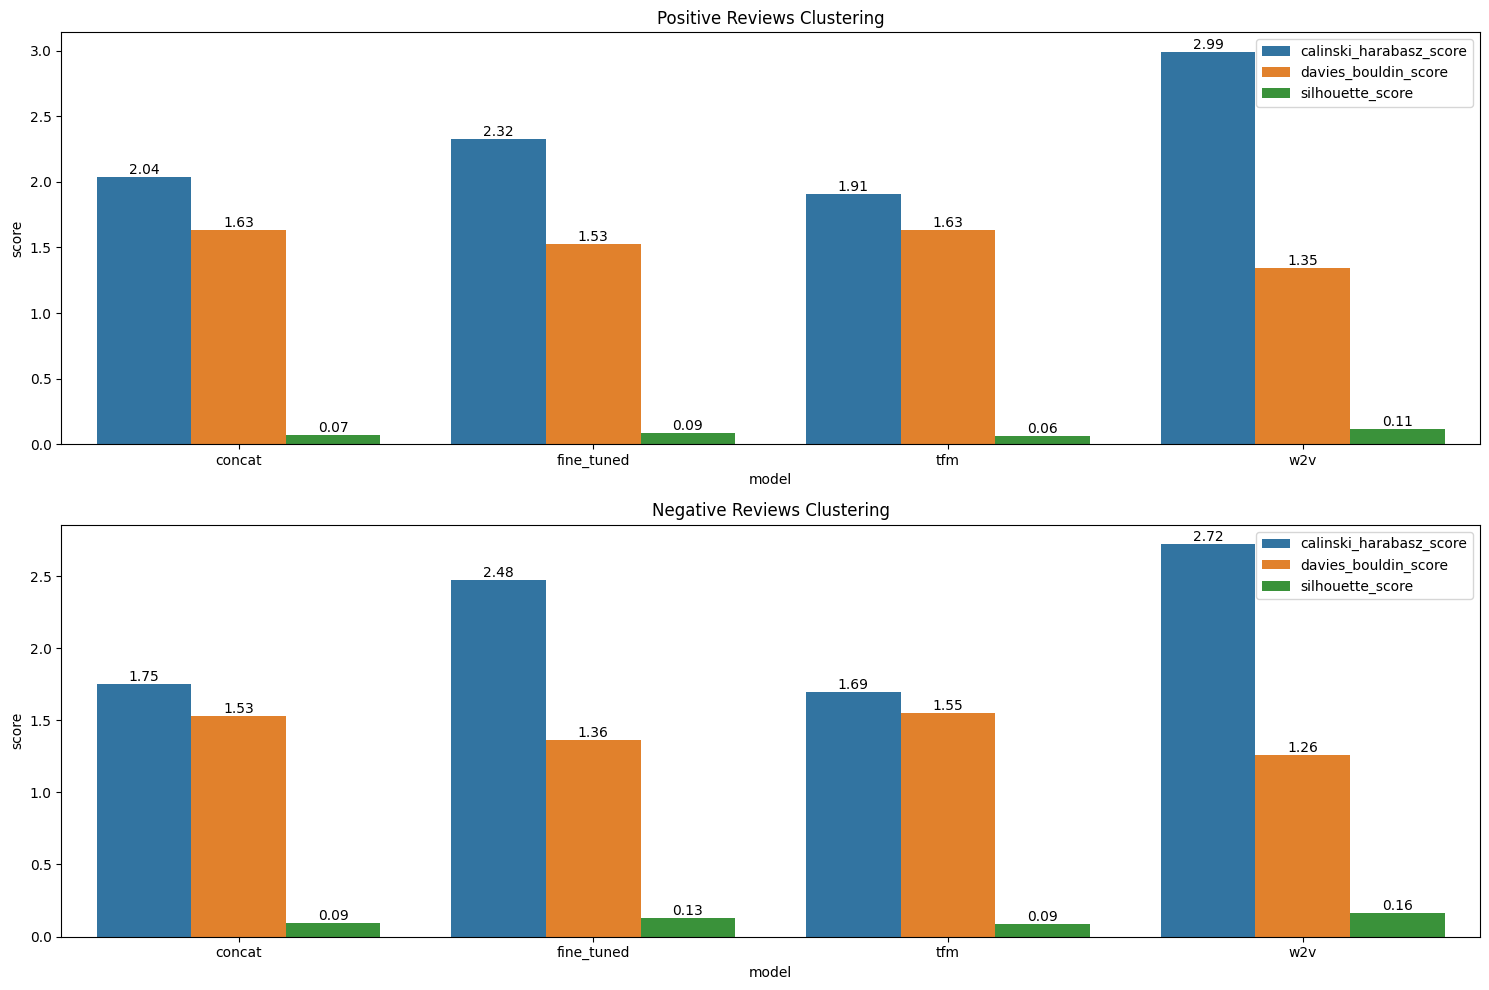

In [121]:
# Plot the score in a barplot
scores_df = pd.DataFrame(scores, columns=["model", "sentiment", "metric", "score"])

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for row, sentiment in enumerate(["positive", "negative"]):

    data = scores_df[scores_df["sentiment"] == sentiment]
    data_agg = data.groupby(["model", "metric"])["score"].mean().reset_index()

    sns.barplot(data_agg, x="model", y="score", hue="metric", ax=ax[row])

    # Add the score above the bar
    for container in ax[row].containers:
        ax[row].bar_label(container, fmt="%.2f", label_type="edge")

    ax[row].set_title(f"{sentiment.title()} Reviews Clustering")
    ax[row].legend(loc="upper right")

fig.tight_layout()
plt.show()

# Summary

---



In this notebook, we compare various word vector sources for clustering customer reviews.

The evaluation results, based on clustering metrics, indicate that the Word2Vec model performs the best among the models tested. Additionally, the fine-tuned Transformer model shows a slight improvement over the pretrained Transformer model.

However, it is important to note that we have not performed extensive hyperparameter tuning in this project, and the dataset size is relatively small. A comparison of inference times is also necessary, which we plan to address these in future work.

### References

*   https://huggingface.co/blog/train-sentence-transformers
*   https://github.com/balmasi/g2_reviews_llm_topic_modeling

### Wrap Up!

In [ ]:
# # Save the train and test set for future projects
# upload_csv_to_gcs(train_df, bucket, "customer_review_train.csv")
# upload_csv_to_gcs(test_df, bucket, "customer_review_test.csv")

In [ ]:
# cols = ["processed_text", "tokens"]
# processed_dataset[cols].to_parquet("processed_dataset_ckpt.parquet",
#                                    index=False)
# !gsutil cp "processed_dataset_ckpt.parquet" "gs://customer_review_hawaii/"
# !rm "processed_dataset_ckpt.parquet"

In [ ]:
# # Save Word2Vec Model
# w2v_encoder.model.save("word2vec_model.model")